# 1.
Изучите удержание игроков «Королевства гномов» в динамике.
Используя таблицу динамики удержания, постройте графики истории изменений удержания на конец первой и второй недели «жизни» пользователей по каждому источнику привлечения (channel) с разбивкой на платящих и неплатящих (payer).
Чтобы получить таблицу динамики удержания, вызовите заданную в коде функцию get_retention().
Горизонт анализа сохранён в переменной analysis_horizon, а момент анализа — в observation_date.

Подсказка
Чтобы получить сырые данные, таблицу удержания и таблицу динамики удержания с разбивкой по каналу привлечения и совершению покупок, вызовите функцию get_retention(), передав ей такие аргументы: users, visits, observation_date, analysis_horizon и dimensions=['channel'].
Результат вызова сохраните в трёх переменных, например retention_raw, retention и retention_history.
Конец первой и второй недели «жизни» пользователей — это седьмой и четырнадцатый дни соответственно, то есть 6-й и 13-й лайфтаймы. Если вы сохранили таблицу динамики удержания в retention_history, сделайте срез так: retention_history[[6, 13]]. Результат сохраните в новую переменную, например report.
Число строк в таблице графиков равно количеству уникальных значений столбца payer из датафрейма users, а число столбцов — количеству уникальных значений столбца channel из того же датасета. Найдите их, применив функцию len() и метод unique().
Далее напишите цикл for, который сохранит в две переменные цикла, например i и payer, результат вызова enumerate() с уникальными значениями payer в качестве аргумента. Во внутреннем цикле сделайте то же самое, но на этот раз передайте enumerate() уникальные значения channel, сохранив результат в других двух переменных цикла, например j и channel.
Отфильтруйте срез таблицы динамики удержания методом query(), в качестве условия передав ему такое выражение: 'payer == @payer and channel == @channel'. Затем исключите столбцы payer и channel из индексов методом droplevel(). В параметре ax метода plot() вызовите функцию subplot(), передав ей число строк и столбцов в таблице графиков, а также позицию каждого графика: i * num_cols + j + 1. При необходимости подставьте соответствующие названия переменных.

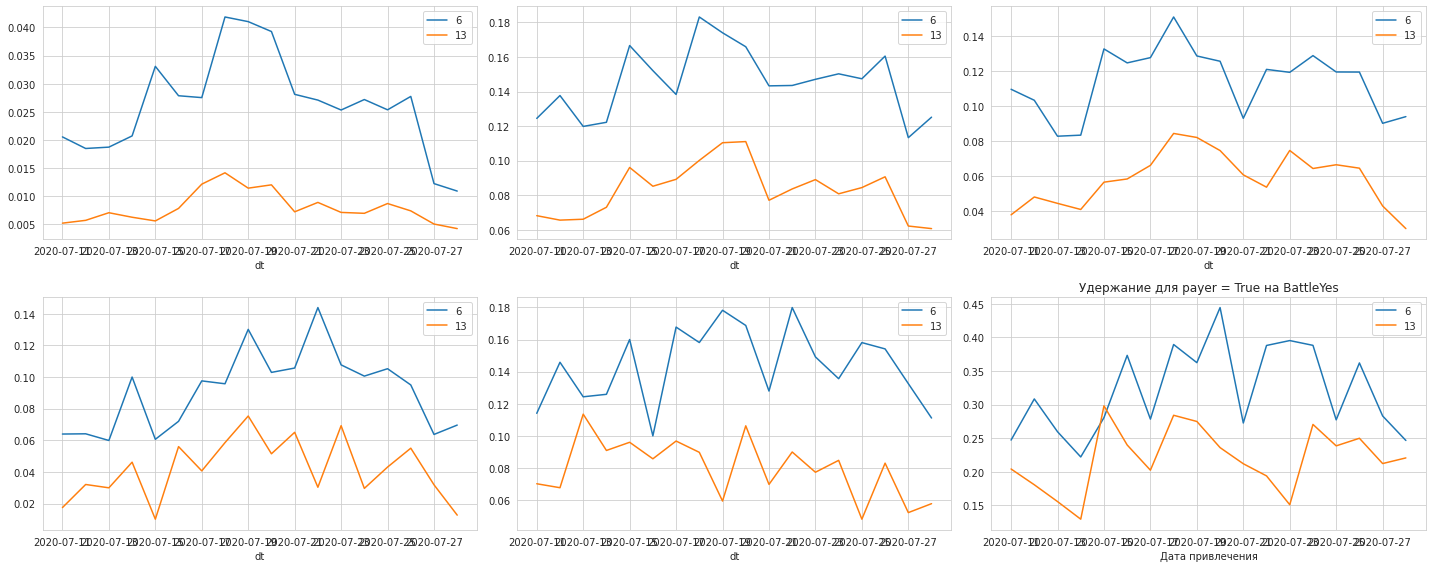

In [4]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt


def get_retention(
        profiles,
        sessions,
        observation_date,
        horizon_days,
        dimensions=[],
        ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
            result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
                .agg({'user_id': 'nunique'})
                .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time


users = pd.read_csv('datasets/ch02_problems02_users.csv')  # профили
visits = pd.read_csv('datasets/ch02_problems02_visits.csv')  # журнал сессий

# преобразование данных о времени
users['dt'] = pd.to_datetime(users['dt']).dt.date
users['first_ts'] = pd.to_datetime(users['first_ts'])
visits['session_start'] = pd.to_datetime(visits['session_start'])

observation_date = users['dt'].max()  # момент анализа

analysis_horizon = 14  # горизонт анализа

retention_raw, retention, retention_history = get_retention(profiles=users,
                                                            sessions=visits,
                                                            observation_date=observation_date,
                                                            horizon_days=analysis_horizon,
                                                            dimensions=['channel'])
# получите сырые данные, таблицу удержания и таблицу динамики удержания

plt.figure(figsize = (20, 8))  # размер сетки для графиков

report =  retention_history[[6, 13]]# сделайте срез таблицы динамики удержания

num_rows = len(users['payer'].unique())# задайте количество строк в таблице графиков
num_cols = len(users['channel'].unique())# задайте количество столбцов в таблице графиков

# постройте графики по аналогии с примером из прошлого урока:

# напишите цикл for для перебора номеров и уникальных значений payer
# и внутренний цикл для перебора номеров и уникальных значений channel
for i, payer in enumerate(users['payer'].unique()):
    for j, channel in enumerate(users['channel'].unique()):
        (
            report.query('payer == @payer and channel == @channel')
                .droplevel(['payer', 'channel'])# отфильтруйте датафрейм по наличию покупок и каналу
                # устраните payer и channel из индексов
                .plot(
                grid=True,
                ax= plt.subplot(num_rows, num_cols, i*num_cols + j + 1) # постройте каждый график в своей ячейке
            )
        )
plt.xlabel('Дата привлечения')
plt.title('Удержание для payer = {} на {}'.format(payer, channel))

plt.tight_layout()
plt.show()